# INF250 - Assignment 2

In [1]:
import skimage
from skimage import io, color, filters, feature, measure, morphology
import numpy as np
import matplotlib.pyplot as plt

/var/folders/gf/ltk57v_95wdgd_bbsrsl7_9m0000gn/T/ipykernel_18986/1691170106.py:2: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skimage.io.imshow(image);


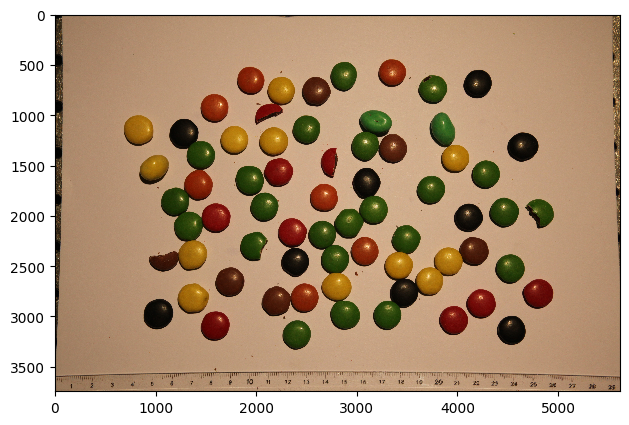

In [2]:
image = skimage.io.imread("IMG_2754_nonstop_alltogether.JPG")
skimage.io.imshow(image);

In [3]:
import skimage.color

# Fix weird 2-channel or RGBA images
if image.ndim == 2:
    image = skimage.color.gray2rgb(image)
elif image.shape[2] == 4:  # RGBA -> RGB
    image = skimage.color.rgba2rgb(image)
elif image.shape[2] == 2:  # Gray + Alpha -> just use first channel
    image = skimage.color.gray2rgb(image[..., 0])


/var/folders/gf/ltk57v_95wdgd_bbsrsl7_9m0000gn/T/ipykernel_18986/2563508896.py:12: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skimage.io.imshow(blurred_image);


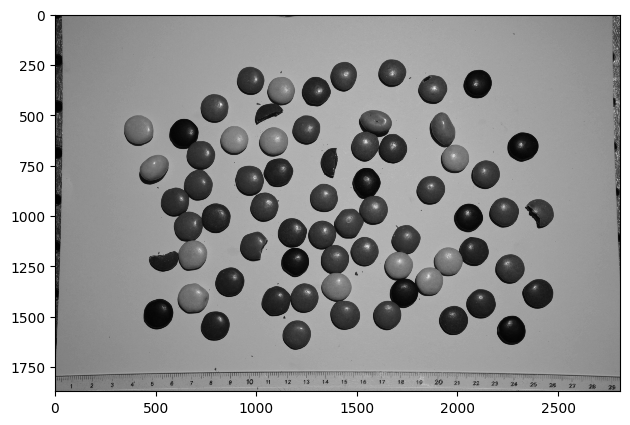

In [4]:
SCALE = 0.5

# Convert the image to grayscale
gray_image = skimage.color.rgb2gray(image)

small_image = skimage.transform.rescale(gray_image, SCALE, anti_aliasing=True)

# Reduce the noise in the image with gaussian filter
blurred_image = skimage.filters.gaussian(small_image, sigma=1)

# Display the processed images
skimage.io.imshow(blurred_image);

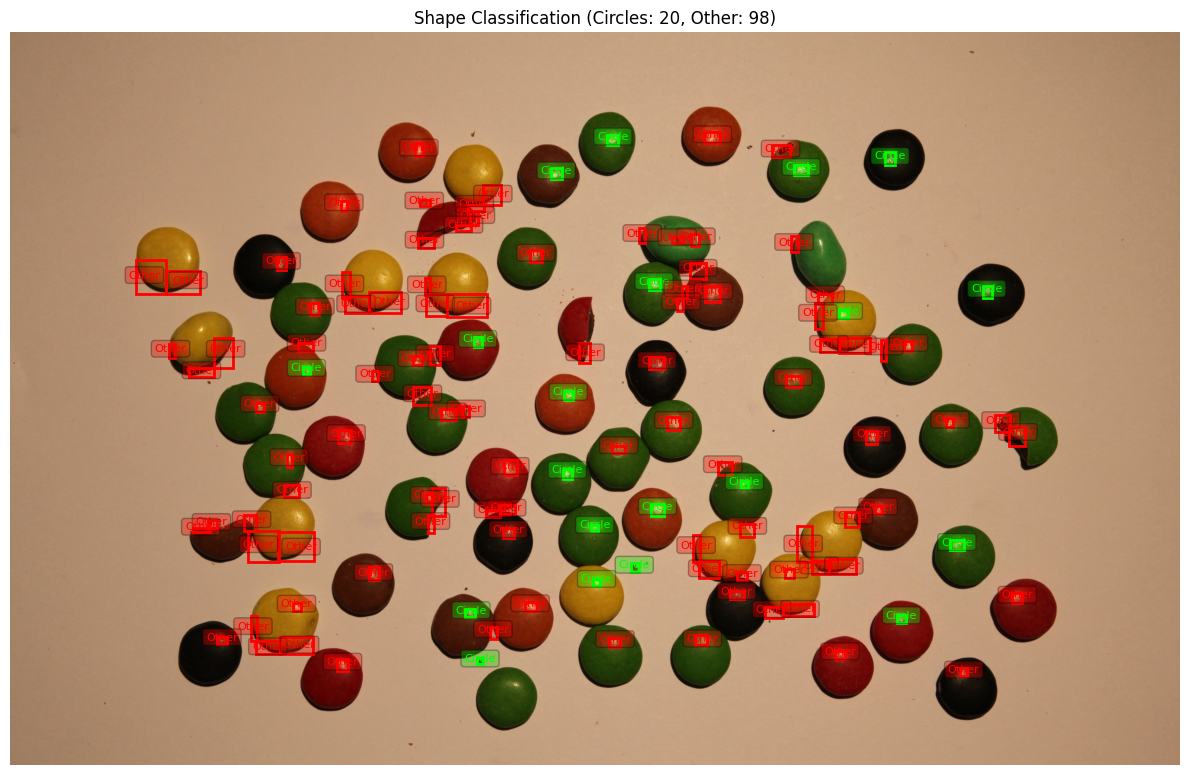


Detected 20 circles and 98 other shapes


In [ ]:
import numpy as np
import skimage
from skimage import filters, morphology, measure, feature, segmentation
from scipy import ndimage
import matplotlib.pyplot as plt

image = skimage.io.imread('IMG_2754_nonstop_alltogether.jpg')

crop_top = 100
crop_bottom = -250
crop_left = 100
crop_right = -100

image_cropped = image[crop_top:crop_bottom, crop_left:crop_right]

gray = skimage.color.rgb2gray(image_cropped)
blurred = filters.gaussian(gray, sigma=2)

thresh = filters.threshold_otsu(blurred)
binary = blurred < thresh

binary = morphology.remove_small_objects(binary, min_size=200)
binary = morphology.remove_small_holes(binary, area_threshold=500)
binary = morphology.binary_closing(binary, morphology.disk(5))

distance = ndimage.distance_transform_edt(binary)
local_max_coords = feature.peak_local_max(distance, min_distance=20, labels=binary)

markers = np.zeros(binary.shape, dtype=bool)
markers[tuple(local_max_coords.T)] = True
markers = morphology.dilation(markers, morphology.disk(5))
markers = measure.label(markers)

labels = segmentation.watershed(-distance, markers, mask=binary)

regions = measure.regionprops(labels)

fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(image_cropped)

circles = []
others = []

for region in regions:
    area = region.area
    perimeter = region.perimeter
    
    if area < 200 or perimeter == 0:
        continue
    
    circularity = 4 * np.pi * area / (perimeter ** 2)
    
    major_axis = region.axis_major_length
    minor_axis = region.axis_minor_length
    axis_ratio = minor_axis / major_axis if major_axis > 0 else 0
    
    y, x = region.centroid
    
    if circularity > 0.75 and axis_ratio > 0.85:
        color = 'lime'
        label = "Circle"
        circles.append(region)
    else:
        color = 'red'
        label = "Other"
        others.append(region)
    
    minr, minc, maxr, maxc = region.bbox
    rect = plt.Rectangle((minc, minr), maxc - minc, maxr - minr,
                          fill=False, edgecolor=color, linewidth=2)
    ax.add_patch(rect)
    
    ax.text(x, y, label, color=color, fontsize=8, ha='center',
            bbox=dict(boxstyle='round,pad=0.3', facecolor=color, alpha=0.3))

ax.set_title(f"Shape Classification (Circles: {len(circles)}, Other: {len(others)})")
ax.axis('off')
plt.tight_layout()
plt.show()

print(f"\nDetected {len(circles)} circles and {len(others)} other shapes")